Usaremos la base de datos "Wine Quality", la cual contiene mediciones de características quimicas de vinos, así como indicadores de calidad y tipo de vino tinto o blanco. Pueden encontrar más información en la siguiente liga
http://www3.dsi.uminho.pt/pcortez/wine/

Usaremos 4 variables objetivo: 1) tipo (tinto o blanco), categórica binaria; 2) nivel de acidés (fixed acidity and volatile acidity), valores reales; y 3) calidad (valor entre 0 y 9), catogórica multiple.

Y usaremos el resto de las variables de mediciones químicas como variables independientes. Simularemos que estas variables vienen de dos fuentes distintas, para demostrar la manera en que una red neuronal procesa más de una entrada.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Dense
from tensorflow.keras.utils import plot_model

# Part 1: Load and explore data

In [ ]:
# Read dataset
datafile = "winequalityN.csv"
df = pd.read_csv(datafile).dropna()
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,red,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


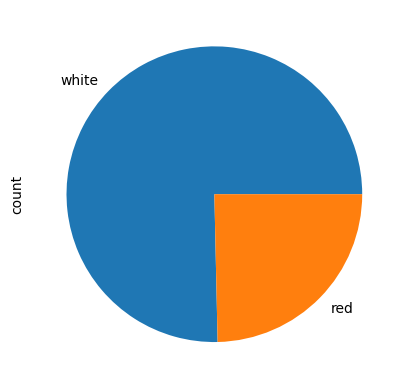

In [ ]:
# See distribution of types
df['type'].value_counts(dropna=False).plot(kind="pie")
plt.show()

In [ ]:
# Convert type from string into categorical
df['type'] = df['type'].astype('category').cat.codes
df['type'].value_counts()

,count
type,
1,4870
0,1593


In [ ]:
# Summary info on data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   int8   
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), int8(1)
memory usage: 662.7 KB


In [ ]:
# See statistical summary
df.iloc[:, 1:].describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505
std,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


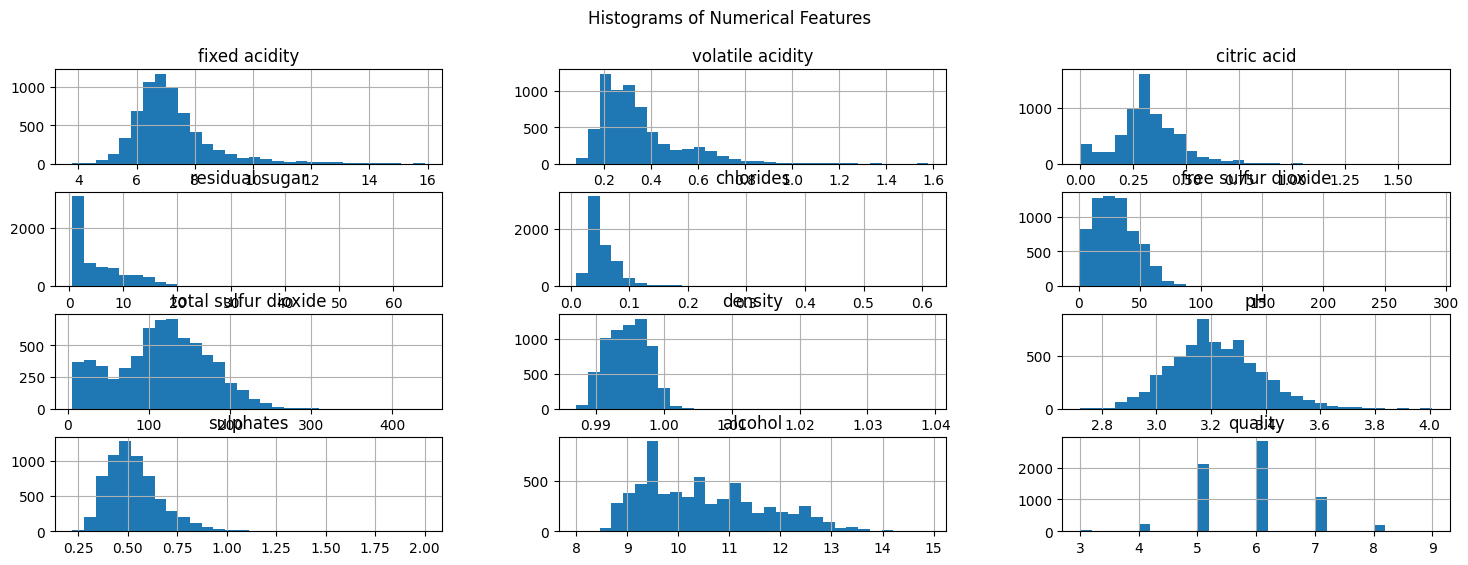

In [ ]:
# Histogram for numerical features
df.iloc[:, 1:].hist(bins=30, figsize=(18, 6))
plt.suptitle('Histograms of Numerical Features')
plt.show()

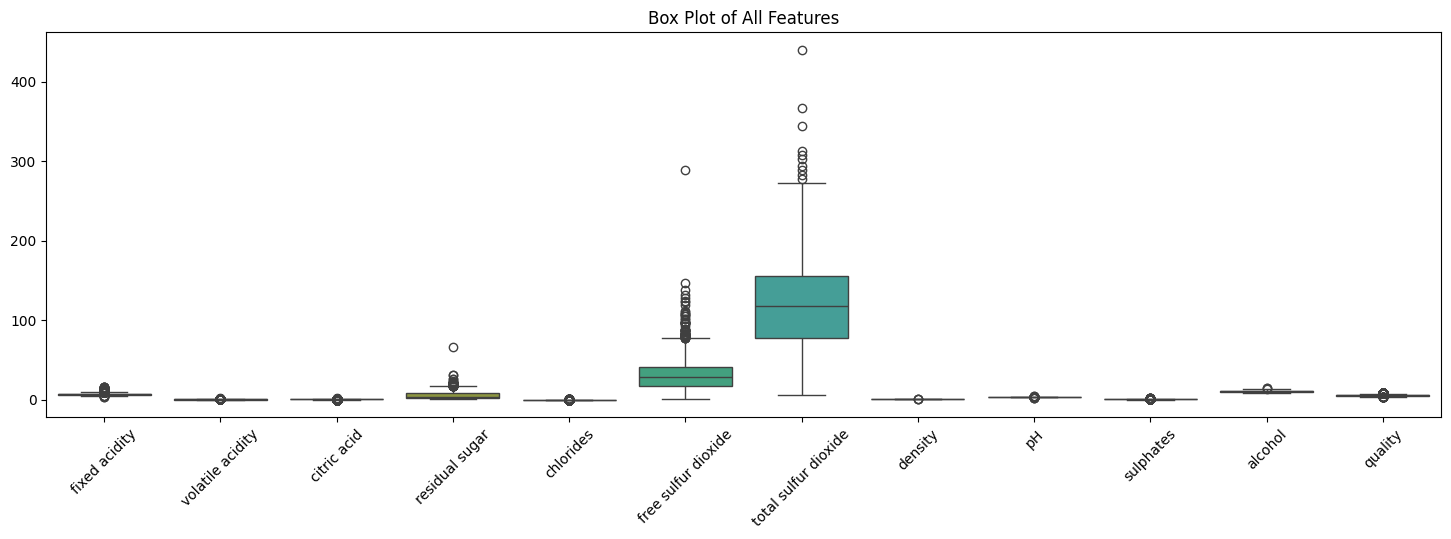

In [ ]:
# Box Plot to identify outliers
plt.figure(figsize=(18, 5))
sns.boxplot(data=df.iloc[:, 1:])
plt.title('Box Plot of All Features')
plt.xticks(rotation=45)
plt.show()

# Part 2: split data into training, validation, and test sets

In [ ]:
# Separate predictors from target variable
X = df[["citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]].to_numpy()
Y = df[["type", "fixed acidity", "volatile acidity", "quality"]].to_numpy()

print(X.shape)
print(Y.shape)

(6463, 9)
(6463, 4)


In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42) # First test set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42) # Then train and validation sets

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(5234, 9)
(5234, 4)
(582, 9)
(582, 4)
(647, 9)
(647, 4)


In [ ]:
# Separate target variables per type: binary, real, and multi-class
y_train_bina = y_train[:, 0]
y_train_real = y_train[:, 1:3]
y_train_mcat = y_train[:, 3]

y_val_bina = y_val[:, 0]
y_val_real = y_val[:, 1:3]
y_val_mcat = y_val[:, 3]

y_test_bina = y_test[:, 0]
y_test_real = y_test[:, 1:3]
y_test_mcat = y_test[:, 3]

print(y_train_bina.shape)
print(y_train_real.shape)
print(y_train_mcat.shape)

(5234,)
(5234, 2)
(5234,)


In [ ]:
# Covert multi-class ("quality") target variable into one-hot encoding representation
y_train_mcat = tf.one_hot(y_train_mcat, 10).numpy()
y_val_mcat = tf.one_hot(y_val_mcat, 10).numpy()
y_test_mcat = tf.one_hot(y_test_mcat, 10).numpy()

print(y_train_mcat.shape)
print(y_val_mcat.shape)
print(y_test_mcat.shape)

(5234, 10)
(582, 10)
(647, 10)


In [ ]:
# Now, just for fun, let's also divide the independent variables to simulate
# having two different inputs, i.e., suppose that for some reason you have two
# different sources of data, and you want to keep them separated, e.g., audio
# and video
x_train_1 = x_train[:, :5]
x_train_2 = x_train[:, 5:]

x_val_1 = x_val[:, :5]
x_val_2 = x_val[:, 5:]

x_test_1 = x_test[:, :5]
x_test_2 = x_test[:, 5:]

print(x_train_1.shape)
print(x_train_2.shape)

(5234, 5)
(5234, 4)


# Part 3: create DL model and train it

In [ ]:
# Create an MLP of two inputs x1=[x1_1, ..., x1_5] and x2=[x2_1, ..., x2_4],
# and multiple outputs y1, y2=[y2_1, y2_2], y3
i1 = Input(shape=(5,), name='input1')
i2 = Input(shape=(4,), name='input2')

h1 = Concatenate()([i1, i2])

h2 = Dense(units=81, activation='relu')(h1)
h3 = Dense(units=16, activation='relu')(h2)

o1 = Dense(units=1, activation='sigmoid', name='out_binary')(h3)
o2 = Dense(units=2, activation='linear', name='out_real')(h3)
o3 = Dense(units=10, activation='softmax', name='out_multicat')(h3)

MLP = Model(inputs=[i1, i2], outputs=[o1, o2, o3])
MLP.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer)       │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input2 (InputLayer)       │ (None, 4)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 9)              │              0 │ input1[0][0],          │
│ (Concatenate)             │                        │                │ input2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 81)             │            810 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 16)             │          1,312 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_binary (Dense)        │ (None, 1)              │             17 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_real (Dense)          │ (None, 2)              │             34 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ out_multicat (Dense)      │ (None, 10)             │            170 │ dense_5[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,343 (9.15 KB)

 Trainable params: 2,343 (9.15 KB)

 Non-trainable params: 0 (0.00 B)

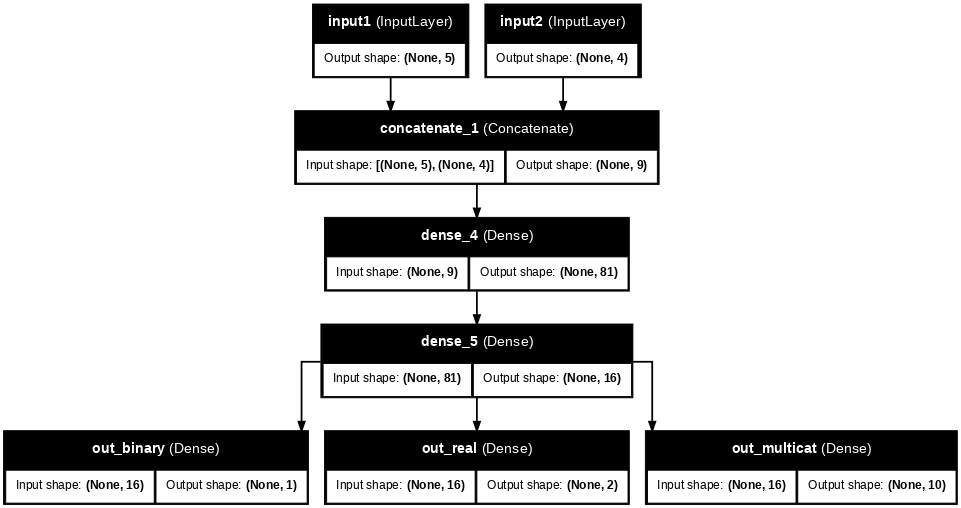

In [ ]:
# Plot a diagram of the MLP model
plot_model(MLP, to_file='MLP.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [ ]:
# Here we define the optimizer and loss function
MLP.compile(optimizer='adam', loss=['binary_crossentropy', 'mse', 'categorical_crossentropy'])
history = MLP.fit(x=[x_train_1, x_train_2], y=[y_train_bina, y_train_real, y_train_mcat], batch_size=32, epochs=50, validation_data=([x_val_1, x_val_2], [y_val_bina, y_val_real, y_val_mcat]))

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 23.9725 - out_binary_loss: 5.8221 - out_multicat_loss: 4.1946 - out_real_loss: 13.9556 - val_loss: 2.7863 - val_out_binary_loss: 0.2774 - val_out_multicat_loss: 1.5120 - val_out_real_loss: 1.0006
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6953 - out_binary_loss: 0.2594 - out_multicat_loss: 1.4132 - out_real_loss: 1.0227 - val_loss: 2.5324 - val_out_binary_loss: 0.2441 - val_out_multicat_loss: 1.3586 - val_out_real_loss: 0.9545
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5068 - out_binary_loss: 0.2347 - out_multicat_loss: 1.3463 - out_real_loss: 0.9259 - val_loss: 2.4640 - val_out_binary_loss: 0.2500 - val_out_multicat_loss: 1.3087 - val_out_real_loss: 0.9224
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.4194 - out_binary_loss: 0.2272 - out_multicat_loss: 1.3129 - out_real_loss: 0.8792 - val_loss: 2.3056 - val_out_binary_loss: 0.2412 - val_out_multicat_loss: 1.2825 - val_out_

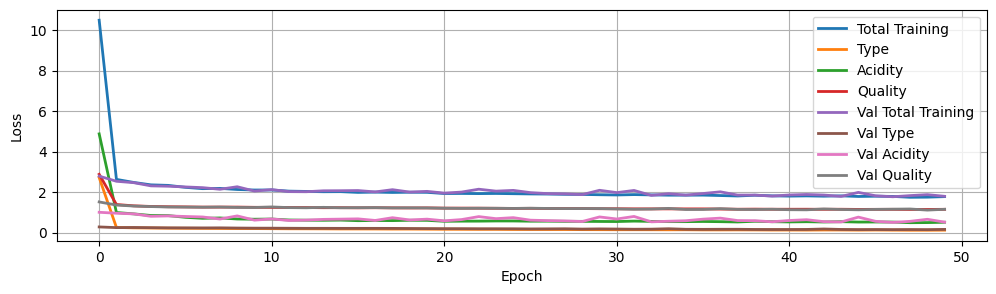

In [ ]:
# Plot loss (The object MLP keeps track of the training and validation performance)
plt.figure(figsize=(12, 3))
plt.plot(MLP.history.history['loss'], label='Total Training', linewidth=2)
plt.plot(MLP.history.history['out_binary_loss'], label='Type', linewidth=2)
plt.plot(MLP.history.history['out_real_loss'], label='Acidity', linewidth=2)
plt.plot(MLP.history.history['out_multicat_loss'], label='Quality', linewidth=2)
plt.plot(MLP.history.history['val_loss'], label='Val Total Training', linewidth=2)
plt.plot(MLP.history.history['val_out_binary_loss'], label='Val Type', linewidth=2)
plt.plot(MLP.history.history['val_out_real_loss'], label='Val Acidity', linewidth=2)
plt.plot(MLP.history.history['val_out_multicat_loss'], label='Val Quality', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# == Q1 ==
# Encuentra una manera de graficar las curvas de pérdida anteriores para poder comprobar si hay, o no, sobre ajuste

In [ ]:
# Evaluate on the test set
MLP.evaluate([x_test_1, x_test_2], [y_test_bina, y_test_real, y_test_mcat])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8279 - out_binary_loss: 0.1115 - out_multicat_loss: 1.2181 - out_real_loss: 0.4985 


[1.770895004272461,
 0.11502240598201752,
 0.4898470342159271,
 1.1672792434692383]

In [ ]:
# Now generate the predictions on the test set
y_hat_bina, y_hat_real, y_hat_mcat = MLP.predict([x_test_1, x_test_2])

print(y_hat_bina.shape)
print(y_hat_real.shape)
print(y_hat_mcat.shape)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(647, 1)
(647, 2)
(647, 10)


# Part 4: Challenge

In [ ]:
# == Q2 ==
# Encuentra la mejor combinación de hiperparámetros posible para mejorar el desempeño del modelo

In [ ]:
# == Q3 ==
# Encuentra alguna manera de visualizar, vis-a-vis, el ground-truth y las predicciones del modelo,
# siendo capaz de identificar las predicciones correctas y las erroneas